In [ ]:
# Importações necessárias
import graphviz
import random
import time
import os
from IPython.display import Image, display, clear_output

In [ ]:
# Estrutura da Árvore 2-3-4
class Node234:
    def __init__(self):
        # Lista para armazenar até 3 chaves por nó (propriedade fundamental da 2-3-4)
        self.chaves = []
        # Lista para armazenar filhos (sempre len(chaves) + 1 filhos)
        self.filhos = []
        # Referência para o nó pai (facilita navegação e operações)
        self.pai = None
        # Flag indicando se é folha (nós folha não têm filhos)
        self.eh_folha = True
    
    def esta_cheio(self):
        # Nó fica cheio com 3 chaves - precisa dividir ao tentar inserir a 4ª
        return len(self.chaves) == 3
    
    def esta_vazio(self):
        # Verifica se nó não contém chaves (usado para validações)
        return len(self.chaves) == 0
    
    def definir_pai(self, pai_node):
        # Define o nó pai (mantém estrutura hierárquica da árvore)
        self.pai = pai_node
    
    def adicionar_filho(self, filho_node):
        # Adiciona um filho ao final da lista, com validações
        if filho_node and not filho_node.esta_vazio():
            self.filhos.append(filho_node)
            filho_node.definir_pai(self)
            # Quando tem filhos, não é mais folha
            self.eh_folha = False
    
    def inserir_filho(self, indice, filho_node):
        # Insere filho em posição específica (usado nas divisões)
        if filho_node and not filho_node.esta_vazio():
            self.filhos.insert(indice, filho_node)
            filho_node.definir_pai(self)
            self.eh_folha = False
    
    def __str__(self):
        # Representação string para debug e visualização
        return str(self.chaves)

class Arvore234:
    def __init__(self):
        # Árvore vazia inicia sem nó raiz (None)
        self.raiz = None
        # Contador de elementos para estatísticas
        self.tamanho = 0
    
    def esta_vazia(self):
        # Verifica se árvore não tem elementos
        return self.raiz is None or self.raiz.esta_vazio()
    
    def buscar(self, chave):
        # BUSCA: Navega da raiz até folhas procurando a chave
        if self.esta_vazia():
            return False
        
        node = self.raiz
        while node:
            i = 0
            # Encontra posição onde chave deveria estar no nó atual
            while i < len(node.chaves) and chave > node.chaves[i]:
                i += 1
            
            # Se encontrou a chave, retorna True
            if i < len(node.chaves) and chave == node.chaves[i]:
                return True
            
            # Se chegou em folha sem encontrar, não existe
            if node.eh_folha:
                return False
            
            # Desce para o filho apropriado
            node = node.filhos[i]
        return False
    
    def inserir(self, chave):
        # INSERÇÃO: Ponto de entrada - trata casos especiais
        
        # Caso 1: Árvore vazia - cria primeira raiz
        if self.esta_vazia():
            self.raiz = Node234()
            self.raiz.chaves.append(chave)
            self.tamanho = 1
            return
        
        raiz = self.raiz
        # Caso 2: Raiz cheia - precisa dividir e crescer árvore
        if raiz.esta_cheio():
            # Cria nova raiz que receberá a chave que sobe da divisão
            nova_raiz = Node234()
            nova_raiz.eh_folha = False
            nova_raiz.adicionar_filho(self.raiz)
            self.raiz = nova_raiz
            # Divide a antiga raiz (agora filho da nova raiz)
            self._dividir_filho(nova_raiz, 0)
            # Insere na nova estrutura
            self._inserir_nao_cheio(nova_raiz, chave)
        else:
            # Caso 3: Raiz não cheia - inserção normal
            self._inserir_nao_cheio(raiz, chave)
        self.tamanho += 1
    
    def _inserir_nao_cheio(self, node, chave):
        # INSERÇÃO EM NÓ NÃO CHEIO: Recursivo com divisões preventivas
        i = len(node.chaves) - 1
        
        if node.eh_folha:
            # CASO FOLHA: Insere diretamente na posição correta
            node.chaves.append(0)  # Expande lista
            # Desloca chaves maiores para direita
            while i >= 0 and chave < node.chaves[i]:
                node.chaves[i + 1] = node.chaves[i]
                i -= 1
            # Insere na posição correta
            node.chaves[i + 1] = chave
        else:
            # CASO NÓ INTERNO: Encontra filho correto e verifica se precisa dividir
            # Encontra índice do filho onde inserir
            while i >= 0 and chave < node.chaves[i]:
                i -= 1
            i += 1
            
            # DIVISÃO PREVENTIVA: Se filho vai ficar cheio, divide antes
            if i < len(node.filhos) and node.filhos[i].esta_cheio():
                self._dividir_filho(node, i)
                # Após divisão, pode precisar ir para novo filho criado
                if chave > node.chaves[i]:
                    i += 1
            
            # Recursão: continua inserção no filho apropriado
            if i < len(node.filhos):
                self._inserir_nao_cheio(node.filhos[i], chave)
    
    def _dividir_filho(self, pai, indice):
        # DIVISÃO: Core do balanceamento - divide nó cheio em dois
        if indice >= len(pai.filhos):
            return
        
        filho = pai.filhos[indice]
        novo_node = Node234()
        novo_node.eh_folha = filho.eh_folha
        
        # DIVISÃO DAS CHAVES: [A, B, C] -> [A] | B sobe | [C]
        # A chave do meio (índice 1) sobe para o pai
        pai.chaves.insert(indice, filho.chaves[1])
        # Chave da direita (índice 2) vai para novo nó
        novo_node.chaves = [filho.chaves[2]]
        # Chave da esquerda (índice 0) fica no filho original
        filho.chaves = [filho.chaves[0]]
        
        # DIVISÃO DOS FILHOS: Se não é folha, divide os 4 filhos em 2+2
        if not filho.eh_folha and len(filho.filhos) > 2:
            # Filhos [2] e [3] vão para o novo nó
            filhos_para_novo = filho.filhos[2:]
            for child in filhos_para_novo:
                novo_node.adicionar_filho(child)
            # Filho original fica com filhos [0] e [1]
            filho.filhos = filho.filhos[:2]
        
        # Insere novo nó como filho do pai na posição correta
        pai.inserir_filho(indice + 1, novo_node)
    
    def remover(self, chave):
        # REMOÇÃO: Simplificada - remove e ajusta estrutura se necessário
        if self.esta_vazia():
            return False
        
        if self._remover_node(self.raiz, chave):
            self.tamanho -= 1
            # Ajuste pós-remoção: se raiz ficou vazia
            if self.raiz.esta_vazio() and len(self.raiz.filhos) > 0:
                # Promove único filho restante para ser nova raiz
                self.raiz = self.raiz.filhos[0]
                self.raiz.definir_pai(None)
            elif self.raiz.esta_vazio() and len(self.raiz.filhos) == 0:
                # Árvore ficou completamente vazia
                self.raiz = None
            return True
        return False
    
    def _remover_node(self, node, chave):
        # REMOÇÃO RECURSIVA: Navega e remove (versão simplificada)
        if not node or node.esta_vazio():
            return False
        
        i = 0
        # Encontra posição da chave no nó
        while i < len(node.chaves) and chave > node.chaves[i]:
            i += 1
        
        if node.eh_folha:
            # FOLHA: Remove diretamente se encontrar
            if i < len(node.chaves) and chave == node.chaves[i]:
                node.chaves.pop(i)
                return True
            return False
        
        # NÓ INTERNO: Remove e continua recursão
        if i < len(node.chaves) and chave == node.chaves[i]:
            node.chaves.pop(i)
            return True
        else:
            # Continua busca no filho apropriado
            if i < len(node.filhos):
                return self._remover_node(node.filhos[i], chave)
            return False
    
    def percorrer_em_ordem(self):
        # TRAVERSAL: Percorre árvore em ordem crescente (in-order)
        if self.esta_vazia():
            return []
        
        resultado = []
        pilha = [(self.raiz, 0)]  # (nó, índice_atual)
        
        while pilha:
            node, idx = pilha.pop()
            
            if not node or node.esta_vazio():
                continue
            
            if node.eh_folha:
                # FOLHA: Adiciona todas as chaves (já estão ordenadas)
                resultado.extend(node.chaves)
            else:
                # NÓ INTERNO: Processa filhos intercalados com chaves
                if idx < len(node.chaves):
                    # Continua processamento deste nó
                    pilha.append((node, idx + 1))
                    # Adiciona chave atual
                    resultado.append(node.chaves[idx])
                    # Processa filho à direita da chave
                    if idx + 1 < len(node.filhos):
                        pilha.append((node.filhos[idx + 1], 0))
                
                # Processa primeiro filho (à esquerda de todas as chaves)
                if idx == 0 and len(node.filhos) > 0:
                    pilha.append((node.filhos[0], 0))
        
        # Ordena resultado final (garantia de ordem correta)
        return sorted(resultado)
    
    def obter_altura(self):
        # ALTURA: Calcula altura usando BFS (todas folhas no mesmo nível)
        if self.esta_vazia():
            return 0
        
        altura = 0
        fila = [self.raiz]
        
        # BFS: Processa nível por nível
        while fila:
            altura += 1
            nivel_size = len(fila)
            
            # Processa todos nós do nível atual
            for _ in range(nivel_size):
                node = fila.pop(0)
                if node and not node.eh_folha and node.filhos:
                    # Adiciona apenas filhos válidos para próximo nível
                    filhos_validos = [f for f in node.filhos if f and not f.esta_vazio()]
                    fila.extend(filhos_validos)
            
            if not fila:
                break
        
        return altura

Construção e balanceamento
Valores a serem inseridos: [30, 58, 4, 63, 59, 68, 74, 94, 83, 23, 40, 92, 97, 1, 24, 64, 32, 60, 54, 55, 86]

Passo 21/21: Inserindo valor 86
  Total de nodes: 21
  Altura atual: 3
  --> Árvore após inserir 86:


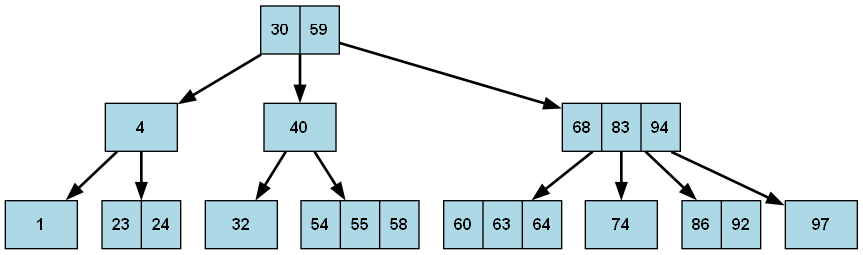



Construção completa
Árvore final com 21 nodes e altura 3


Demonstrações das funções de busca e remoção:

Buscando por 40: True
Buscando por 999: False

Removendo 68...
Nodes após remoção: 20
Verificando se 68 ainda existe: False

--> Árvore final após remoção de 68:


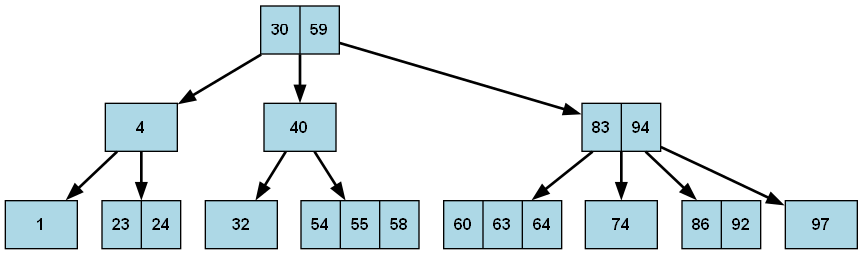



Processo concluído


In [4]:
# Plotagem e demonstração da construção passo a passo
def plotar_arvore_234_inline(arvore_234, nome_arquivo='arvore_234_construcao'):
    # VISUALIZAÇÃO: Cria gráfico da árvore usando Graphviz
    dot = graphviz.Digraph(comment='Árvore 2-3-4')
    
    # CONFIGURAÇÃO VISUAL: Define aparência dos nós e arestas
    dot.attr(rankdir='TB')  # Top-Bottom (raiz em cima)
    dot.attr('node', shape='record', style='filled', fillcolor='lightblue', 
             fontsize='12', fontname='Arial Bold')
    dot.attr('edge', color='black', penwidth='2')
    
    # Verifica se árvore está vazia
    if arvore_234.esta_vazia():
        dot.node('0', 'Árvore Vazia')
    else:
        # BFS: Percorre árvore nível por nível para plotagem
        fila = [(arvore_234.raiz, 0)]
        node_id = 0
        
        while fila:
            node, current_id = fila.pop(0)
            
            # Filtra nós vazios (não aparecem na visualização)
            if not node or node.esta_vazio():
                continue
            
            # RÓTULO DO NÓ: Chaves separadas por "|" (formato record do Graphviz)
            chaves_texto = '|'.join(map(str, node.chaves))
            dot.node(str(current_id), chaves_texto)
            
            # ARESTAS: Conecta nós pais com filhos válidos
            if not node.eh_folha and node.filhos:
                for filho in node.filhos:
                    if filho and not filho.esta_vazio():
                        node_id += 1
                        fila.append((filho, node_id))
                        # Cria aresta do nó atual para o filho
                        dot.edge(str(current_id), str(node_id))
    
    # RENDERIZAÇÃO: Gera arquivo PNG
    try:
        dot.format = 'png'
        dot.render(nome_arquivo, cleanup=True)
        return f"{nome_arquivo}.png"
    except Exception as e:
        print(f"Erro ao renderizar: {e}")
        return None

# DEMONSTRAÇÃO INTERATIVA: Mostra construção passo a passo
print("Construção e balanceamento")

# Gera lista de valores aleatórios para demonstração
valores = random.sample(range(1, 100), 21)
print(f"Valores a serem inseridos: {valores}")
print("\n")

# Inicializa árvore vazia
arvore_234 = Arvore234()
nome_arquivo_fixo = 'arvore_234_construcao'

# LOOP PRINCIPAL: Inserção passo a passo com visualização
for i, valor in enumerate(valores, 1):
    # Limpa output anterior para efeito de animação
    clear_output(wait=True)
    
    # Mostra informações do estado atual
    print("Construção e balanceamento")
    print(f"Valores a serem inseridos: {valores}")
    print(f"\nPasso {i}/21: Inserindo valor {valor}")
    
    # INSERÇÃO: Chama função de inserção
    arvore_234.inserir(valor)
    
    # ESTATÍSTICAS: Mostra métricas após inserção
    print(f"  Total de nodes: {arvore_234.tamanho}")
    print(f"  Altura atual: {arvore_234.obter_altura()}")
    print(f"  --> Árvore após inserir {valor}:")
    
    # PLOTAGEM: Gera e exibe visualização
    arquivo_png = plotar_arvore_234_inline(arvore_234, nome_arquivo_fixo)
    
    if arquivo_png and os.path.exists(arquivo_png):
        display(Image(arquivo_png))
    
    # PAUSA: Tempo para visualização (1.5 segundos)
    time.sleep(1.5)

# RELATÓRIO FINAL: Estatísticas da construção completa
print("\n")
print("Construção completa")
print(f"Árvore final com {arvore_234.tamanho} nodes e altura {arvore_234.obter_altura()}")

# DEMONSTRAÇÕES ADICIONAIS: Testa operações básicas
print("\n")
print("Demonstrações das funções de busca e remoção:")

# TESTE DE BUSCA: Procura valor existente e inexistente
valor_busca = valores[10]  # Pega um valor da lista (existe)
print(f"\nBuscando por {valor_busca}: {arvore_234.buscar(valor_busca)}")
print(f"Buscando por 999: {arvore_234.buscar(999)}")  # Valor inexistente

# TESTE DE REMOÇÃO: Remove um valor e verifica
valor_remocao = valores[5]  # Pega outro valor da lista
print(f"\nRemovendo {valor_remocao}...")
arvore_234.remover(valor_remocao)
print(f"Nodes após remoção: {arvore_234.tamanho}")
print(f"Verificando se {valor_remocao} ainda existe: {arvore_234.buscar(valor_remocao)}")

# VISUALIZAÇÃO FINAL: Mostra árvore após remoção
print(f"\n--> Árvore final após remoção de {valor_remocao}:")
arquivo_png_final = plotar_arvore_234_inline(arvore_234, 'arvore_234_final')
if arquivo_png_final and os.path.exists(arquivo_png_final):
    display(Image(arquivo_png_final))

print("\n")
print("Processo concluído")